## Introduction

#### Machine Learning model to predict the weekly dispatch count of the warehouse based on the different warehouses' product-wise daily dispatch data.

### Import the necessary packages.

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Import train and test dataset

In [82]:
train=pd.read_csv("/content/gdrive/MyDrive/HE_tredence-data-scientist-hiring-challenge_2022/train.csv")
test=pd.read_csv("/content/gdrive/MyDrive/HE_tredence-data-scientist-hiring-challenge_2022/test.csv")

### Pre-Processing

In [83]:
def pre_process(df):
  
  df=df.rename(columns={col:col.lower() for col in df.columns.values}) # convert to lowercase

  df=df.drop(columns='is_weekend') #drop column

  #missing value indicator
  def na_indicator(df):
    for i in df.columns[df.isnull().any()]:
      df[f"{i}_isnull"]=df[i].isnull().astype('int')
    return df

  df=na_indicator(df)  

  #warehouse wise unique latitude and longitude
  lat_long=df.groupby(['warehouse_id','latitude','longitude'])['latitude'].agg({'min'}).reset_index().iloc[:,:-1]

  
  #drop latitude and longitude columns
  df=df.drop(columns=['latitude','longitude'])

  #left join to main dataframe
  df=pd.merge(df,lat_long,on='warehouse_id',how='left')

  #fill missing for is_warehouse_closed column
  df['is_warehouse_closed']=df['is_warehouse_closed'].fillna('No') #fill most frequent value

  #date feature engineering

  df['date_time']=pd.to_datetime(df["date"].astype('str')) #convert to date-time format
  df['day']=df['date_time'].dt.day #extract day from the date
  df['day_label']=df['date_time'].dt.day_name() #extract the day name from the date
  df['day_number']=df['date_time'].dt.dayofweek #extract the day number from the date
  df['month_number']=df['date_time'].dt.month #extract month number from the date
  df['month_label']=df['date_time'].dt.strftime('%b') #extract the month name from the date
  df['year_quarter']=df['date_time'].dt.quarter #extract the quarter of the year
  df['week_of_year']=df['date_time'].dt.week #extract week of the year from date
  df['year']= df['date_time'].dt.year #extract year
  df['dayofmonth'] = df['date_time'].dt.daysinmonth #extract the day of the month
  df['dayofyear'] = df['date_time'].dt.day_of_year #extract day of the year
  df['weekday']=df['date_time'].dt.day_name().isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).astype('int') #create weekday column
  df['weekend']=df['date_time'].dt.day_name().isin(['Saturday', 'Sunday']).astype('int') #create weekend column
  df['month_start']=df['date_time'].dt.is_month_start.astype('int') #create month start
  df['month_end']=df['date_time'].dt.is_month_end.astype('int') #create month end
  df['quarter_start']=df['date_time'].dt.is_quarter_start.astype('int') #create quarter start
  df['quarter_end']=df['date_time'].dt.is_quarter_end.astype('int') #create quarter end
  df['year_start']=df['date_time'].dt.is_year_start.astype('int') #create year start
  df['year_end']=df['date_time'].dt.is_year_end.astype('int') #create year end
 
  #convert month to seasons
  def month2seasons(x):
    season=""
    if x in [12, 1, 2]:
        season = 'winter'
    elif x in [3, 4, 5]:
        season = 'spring'
    elif x in [6, 7, 8]:
        season = 'summer'
    elif x in [9,10, 11]:
        season = 'autumn'
    return season

  df['seasons']=df['month_number'].apply(month2seasons)

 
  return df

### Numerical feature engineering

In [84]:
def num_feature_eng(df):

  #Groupby min, max, mean, median column
  grpcol=['warehouse_id' ,'product_type',
          'is_warehouse_closed','day_number', 'month_number',
          'week_of_year']
  numcol='daily_dispatch_count'
  df1=df.groupby(grpcol)[numcol].agg({'min','max','mean','median'}).reset_index()
  df1=(df1.rename(columns={col:'grp_'+col for col in df1.loc[:,df1.columns.str.
                                                match("(min|median|max|mean)")]}))
  df=pd.merge(df,df1,on=grpcol,how='left')

  df.set_index('date_time',inplace=True)

  #Rolling min, max, mean, median column

  df['dpc_rolling_mean'] = df['daily_dispatch_count'].rolling(window=5,center=True).mean()
  df['dpc_rolling_median'] = df['daily_dispatch_count'].rolling(window=5,center=True).median()
  df['dpc_rolling_min'] = df['daily_dispatch_count'].rolling(window=5,center=True).min()
  df['dpc_rolling_max'] = df['daily_dispatch_count'].rolling(window=5,center=True).max()

  # Lag features 

  def pre_val(df):
    for i in range(8):
      df[f"dpc_prev_value_{i}"] = df.groupby(['warehouse_id', 'product_type'])['daily_dispatch_count'].shift(i)
      #df[f'dpc_prev_value_2'] = df.groupby(['warehouse_id', 'product_type'])['daily_dispatch_count'].shift(2)
    return df

  df=pre_val(df)  

  df['dpc_expand_mean']=df['daily_dispatch_count'].expanding(2).mean()

  df[['dpc_rolling_median','dpc_rolling_mean','dpc_rolling_min',
      'dpc_rolling_max','dpc_prev_value_1','dpc_prev_value_2',
      'dpc_prev_value_3','dpc_prev_value_4','dpc_prev_value_5',
      'dpc_prev_value_6','dpc_prev_value_7','dpc_expand_mean']]= df[['dpc_rolling_median','dpc_rolling_mean',
                                                   'dpc_rolling_min','dpc_rolling_max',
                                                   'dpc_prev_value_1','dpc_prev_value_2',
                                                   'dpc_prev_value_3','dpc_prev_value_4',
                                                   'dpc_prev_value_5','dpc_prev_value_6',
                                                   'dpc_prev_value_7','dpc_expand_mean']].fillna(0)

  df['daily_dispatch_count_sum']=(df.groupby(['warehouse_id' ,
              'product_type','is_warehouse_closed',
              'year','month_number', 'week_of_year'])['daily_dispatch_count'].transform('sum'))
 
  #df.reset_index()

  return df

#### Apply pre processing steps to train data

In [85]:
train=pre_process(train)

### Apply feature engineering steps to train data

In [86]:
train=num_feature_eng(train)

### Import necessary packages

In [ ]:
!pip install catboost

In [15]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error,r2_score
from sklearn.preprocessing import LabelEncoder

In [87]:
for i,col in enumerate(train.columns):
  print(f"{i}_{col}")   
 

0_id
1_date
2_warehouse_id
3_product_type
4_year
5_month
6_is_warehouse_closed
7_daily_dispatch_count
8_weekly_dispatch_count
9_latitude_isnull
10_longitude_isnull
11_is_warehouse_closed_isnull
12_weekly_dispatch_count_isnull
13_latitude
14_longitude
15_day
16_day_label
17_day_number
18_month_number
19_month_label
20_year_quarter
21_week_of_year
22_dayofmonth
23_dayofyear
24_weekday
25_weekend
26_month_start
27_month_end
28_quarter_start
29_quarter_end
30_year_start
31_year_end
32_seasons
33_grp_mean
34_grp_max
35_grp_min
36_grp_median
37_dpc_rolling_mean
38_dpc_rolling_median
39_dpc_rolling_min
40_dpc_rolling_max
41_dpc_prev_value_0
42_dpc_prev_value_1
43_dpc_prev_value_2
44_dpc_prev_value_3
45_dpc_prev_value_4
46_dpc_prev_value_5
47_dpc_prev_value_6
48_dpc_prev_value_7
49_dpc_expand_mean
50_daily_dispatch_count_sum


### Split predictor and target variables for daily dispatch count model.

In [88]:
X=train.iloc[:,np.r_[2:5,6,11,13,14,15,17,18,20:33]]
y=train['daily_dispatch_count']

### Split predictor and target variables for weekly dispatch count model.

#### Select only weekend data for model

In [89]:
train1=train[train['weekly_dispatch_count_isnull']==0]

In [90]:
X1=train1.iloc[:,np.r_[2:5,6,7,11,13,14,15,17,18,20:51]]
y1=train1['weekly_dispatch_count']

### Split train, validation data for daily dispatch count model.

In [91]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.4, random_state=42,shuffle=True)

### Split train, validation data for weekly dispatch count model.

In [92]:
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(
    X1, y1, test_size=0.4,random_state=44,shuffle=True)

### Train daily dispatch count model.

In [ ]:
daily_cat_reg = CatBoostRegressor(random_seed=1555
                              )
daily_cat_reg.fit(X_train, y_train,early_stopping_rounds=200,
              cat_features=['warehouse_id', 'product_type', 'is_warehouse_closed', 'seasons'],
              eval_set=(X_valid, y_valid)
              )
             

### Evaluate daily dispatch count model.

In [94]:
pred1=daily_cat_reg.predict(X_valid)
r2_score(y_valid, pred1)

0.8651888103054194

### Train weekly dispatch count model.

In [ ]:
weekly_cat_reg = CatBoostRegressor(eval_metric='MAPE')
weekly_cat_reg.fit(X_train1, y_train1,early_stopping_rounds=100,
              cat_features=['warehouse_id', 'product_type', 'is_warehouse_closed', 'seasons'],
              eval_set=(X_valid1, y_valid1)
              )
             

### Evaluate weekly dispatch count model.

In [96]:
pred2=weekly_cat_reg.predict(X_valid1)
mean_absolute_percentage_error(y_valid1, pred2)

0.026315488978452324

### Daily dispatch model feature importance

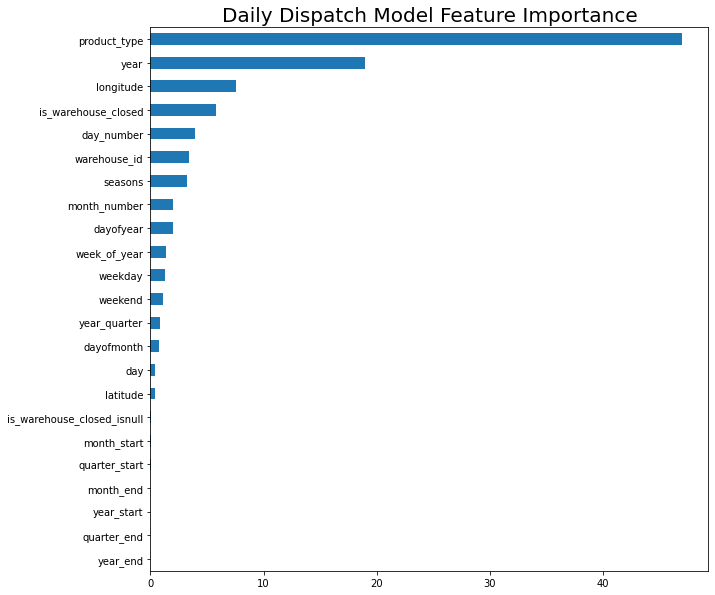

In [109]:
pd.Series(daily_cat_reg.feature_importances_,daily_cat_reg.feature_names_).sort_values(axis=0, ascending=True).plot(kind='barh',figsize=(10,10));
plt.title('Daily Dispatch Model Feature Importance',fontsize=20);

### Weekly dispatch model feature importance

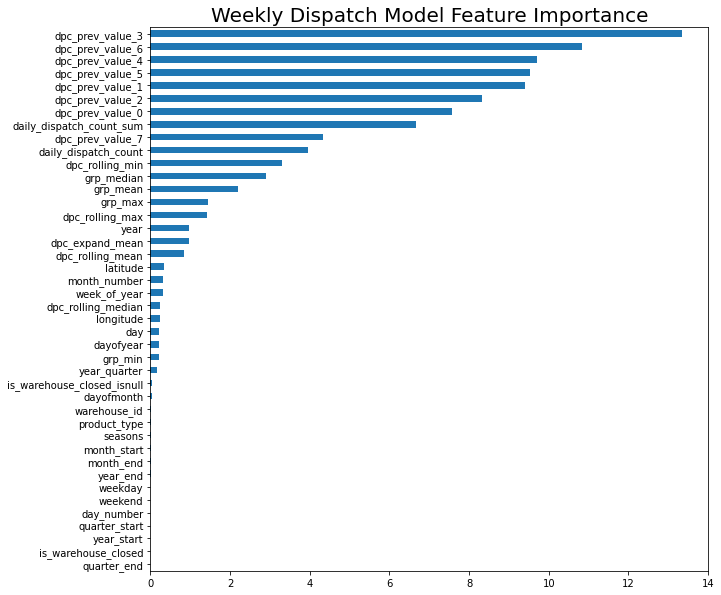

In [108]:
pd.Series(weekly_cat_reg.feature_importances_,weekly_cat_reg.feature_names_).sort_values(axis=0, ascending=True).plot(kind='barh',figsize=(10,10));
plt.title('Weekly Dispatch Model Feature Importance',fontsize=20);

#### Apply the pre process steps to test data.

In [99]:
test=pre_process(test)

### Predict daily dispatch count for test data.

In [100]:
test['daily_dispatch_count']=np.clip(daily_cat_reg.predict(test.loc[:,X.columns]),a_min=0,a_max=17)

#### Apply the feature engineering steps to test data.

In [101]:
test=num_feature_eng(test)

### Predict weekly dispatch count for test data.

In [102]:
test['weekly_dispatch_count']=weekly_cat_reg.predict(test.loc[:,X1.columns])

### Read submission data.

In [32]:
sub=pd.read_csv("/content/gdrive/MyDrive/HE_tredence-data-scientist-hiring-challenge_2022/submission_weekly.csv")

### Merge the prediction with submission data.

In [ ]:
res=pd.merge(sub['ID'],test[['id','weekly_dispatch_count']],left_on=['ID'],right_on=['id'],how='left')

### Write the final submission

In [ ]:
res[['ID','weekly_dispatch_count']].to_csv('final_submission.csv',index=False)

### Daily Dispatch Count From Warehouse Prediction Plot

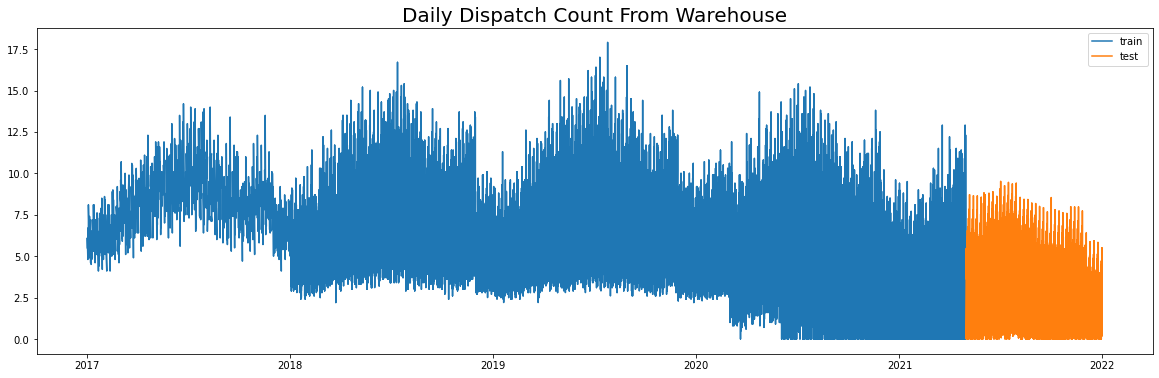

In [111]:
_=plt.figure(figsize=(20,6));
plt.plot(train['daily_dispatch_count'],label='train');
plt.plot(test['daily_dispatch_count'],label='test');
plt.legend();
plt.title('Daily Dispatch Count From Warehouse',fontsize=20);

### Weekly Dispatch Count From Warehouse Prediction Plot

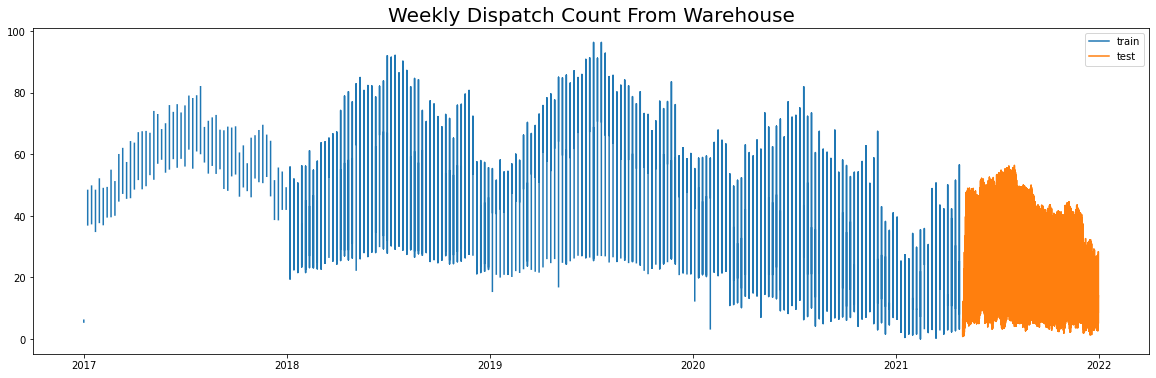

In [110]:
_=plt.figure(figsize=(20,6));
plt.plot(train['weekly_dispatch_count'],label='train');
plt.plot(test['weekly_dispatch_count'],label='test');
plt.legend();
plt.title('Weekly Dispatch Count From Warehouse',fontsize=20);